# Notebook for subtask-A of phase one

## Fitting a model to an amalgamation of the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

from time import time
from tqdm import tqdm

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define some functions

- replace_nan fills NaN values with column means. We don't use it but it was useful for exploratory analysis
- show_nans is also for exploration
- convert_weekdays moves weekday strings into integers from one to seven
- score_abs_error takes a model with SKLEARN syntax and used it to predict the number of bikes based on input data, then return the mean absolute error. round_ specifies whether output should be rounded to integers.
- reasonable_predictions is a bit redundant, taking a model and data and predicting


In [2]:
def replace_nan(df):
    nan_cols = df[df.columns[df.isnull().any()]].columns
    nan_cols = nan_cols.drop('bikes')
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    n_stations = np.unique(df['station'])
    print(f'\nThere are {n_stations} stations')
    print(f'There are {df.shape[0] - df.dropna().shape[0]} rows containing missing data\n')

    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7])
    return df
    
def score_abs_error(model, data, num_docks, round_ = False):
    if round_ == True:
        y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy()) * num_docks  )
    else:
        y_pred = model.predict(data.iloc[:,:-1].to_numpy()) * num_docks
    y_gold = data["bikes"].to_numpy() * num_docks
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    
    #y_pred = np.around(y_pred)
    return y_pred


The next cell has functions to remove unwanted features, add our new isOff feature, and scale data. It reads all the training files and concatenates them into one dataframe.

In [3]:
pd.options.mode.chained_assignment = None

def is_hol_weekend(row):
    if row['weekday'] == 6 or row['weekday'] == 7:
        return 1
    if row['isHoliday'] == 1:
        return 1
    if row['hour'] > 17 or row['hour'] < 9:
        return 1
    return 0

def generate_dataframe(dataframe):
    dataframe = convert_weekdays(dataframe)
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["station"]
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    default_columns = list(dataframe.columns)
    
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    default_columns = ["isOff"] + default_columns
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

def prepare_dataframe(dataframe):
    

    del dataframe["month"]
    del dataframe["year"]
    del dataframe["precipitation.l.m2"]

    del dataframe["station"]
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    
    default_columns = list(dataframe.columns)
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)

    
    default_columns = ["isOff"] + default_columns
    default_columns.remove('weekday')

    dataframe = dataframe[default_columns]

    del dataframe['isHoliday']

    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    #print(columns)
    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    dataframe["numDocks"]    
    
    return dataframe, num_docks

df = []


for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    tmp = pd.read_csv(path)

    tmp = tmp.dropna(axis='rows')
    
    df.append(tmp)
    #print(tmp.columns)

df = pd.concat(df, ignore_index=True)

        
train, val = train_test_split(df, test_size=0.2)

train, train_docks = prepare_dataframe(train)
val, val_docks = prepare_dataframe(val)

scaler = RobustScaler()

train[train.columns[:-1]] = scaler.fit_transform(train[train.columns[:-1]])
val[val.columns[:-1]] = scaler.transform(val[val.columns[:-1]])





# Random elimination parameter tuning
## Random forest regressor

This cell uses `HalvingRandomSearchCV` to find near-optimal parameters for a gradient boosting regressor. It takes a while to run with these parameters, so only run it if you really want to. We have the results of a previous search saved if you're pressed for time - see the next cell.

In [4]:

# searched_boost = GradientBoostingRegressor()

# param_distributions = {"max_depth":  randint(2,6),#[2,3,4, 5, 6, None],
#                        "min_samples_split": randint(2, 30),#np.around(np.linspace(2,30,5)).astype(np.int32),
#                        "learning_rate": uniform(0.00001, 0.99999)#np.linspace(0.0001,1,20),
#                        #"n_estimators": np.linspace(5, 5000, 5).astype(np.int32)
#                       }


# search = HalvingRandomSearchCV(searched_boost, param_distributions,
#                                resource='n_estimators', max_resources = 5000, min_resources = 100,
#                                factor = 2 ,cv = 3,     n_candidates =  50,
#                                random_state=0, verbose=1, n_jobs=6).fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

# #print(search.cv_results_)
# results_df = pd.DataFrame(search.cv_results_)
# print(results_df.head())
#results_df.to_csv("search_results.csv")

## Score tracking

 -  vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.31, rounding integers 2.29
 
 - un-vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.33, rounding integers 2.31
 
 - vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, 2.43, 2.42
 
 - un-vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, , loss="absolute_error",  2.4, 2.38

## The next cell scatters the results of the saved search. If you ran the previous cell, it will load the data from that search.

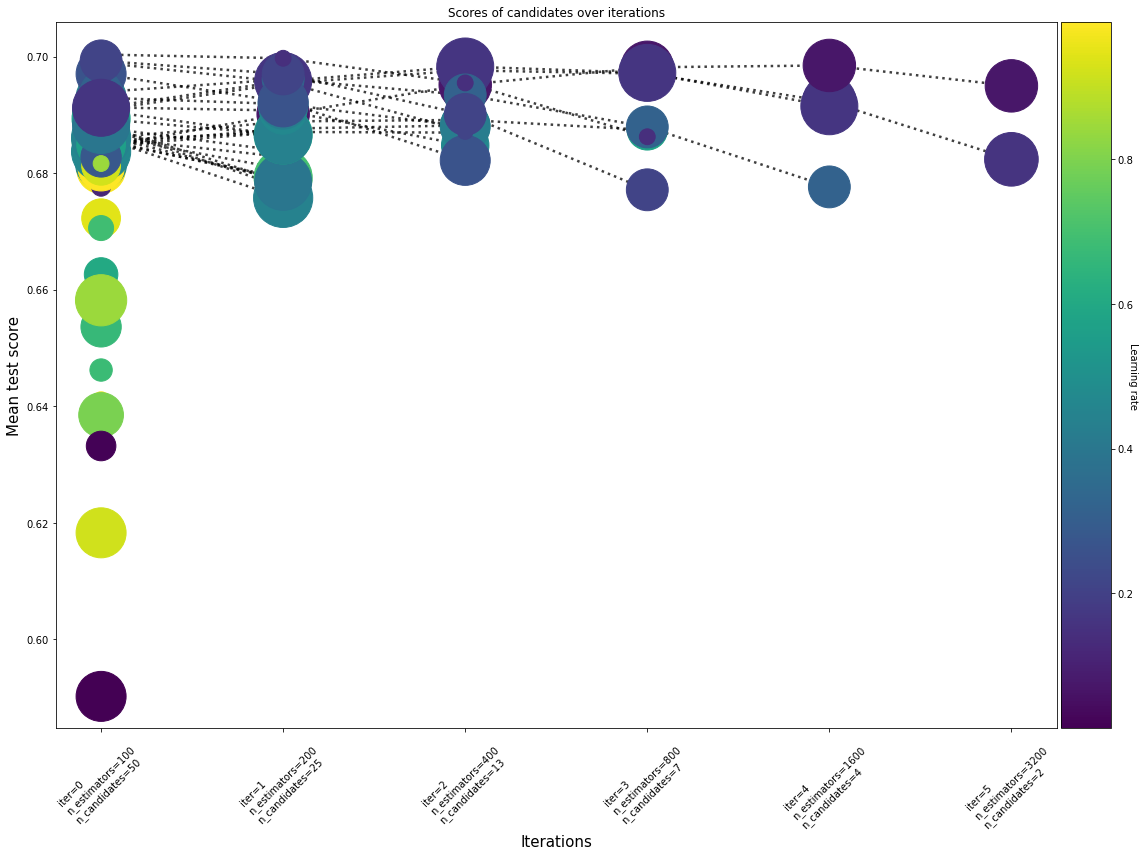

In [5]:
results = pd.read_csv("search_results.csv")
results["params_str"] = results.params.apply(str)

mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)

fig, ax = plt.subplots(figsize=(16,12))

unique_learning_rates = np.unique(results["param_learning_rate"])

for i, lr in enumerate(unique_learning_rates):
    #print(results.columns)
    test_scores = results["mean_test_score"][results["param_learning_rate"] == lr].to_numpy()
    test_deviations = results["std_test_score"][results["param_learning_rate"] == lr].to_numpy()

    ax.plot(np.arange(test_scores.shape[0]), test_scores, linewidth = 2.5, alpha=0.75, linestyle = ':', c='0')

scat = ax.scatter(results["iter"], results["mean_test_score"], c = results["param_learning_rate"], zorder = int(1e5),
                  s = 125*results["param_min_samples_split"].to_numpy().astype(np.float32))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

bar = fig.colorbar(scat, cax = cax)
bar.ax.set_ylabel('Learning rate', rotation=270)

iterations, candidates = np.unique(results["iter"], return_counts=True)
resources = np.unique(results["n_resources"])


labels = [
    f"iter={i}\nn_estimators={resources[i]}\nn_candidates={candidates[i]}"
    for i in iterations
]


#ax.set_ylim([0.66, 0.71])
ax.set_xticks(iterations)
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()

plt.savefig("iterative_halving.png")


plt.show()



## Fit a gradient boosting forest to the training set, using either the results of the search, or parameters we found in testing

In [11]:
from time import time

start = time()
print("initialised")

best_params = {'learning_rate': 0.07104534783730496, 'max_depth': 3, 'min_samples_split': 22, 'n_estimators': 6000, "verbose": 1}
experimental_params = {"n_estimators": 10000, "min_samples_leaf": 5, "max_depth": 5, "learning_rate": 0.005, "verbose": 1, "loss":"absolute_error"}


forest_boost = GradientBoostingRegressor(**experimental_params)#
forest_boost.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

print(f'fitted in {time() - start}s')

initialised
      Iter       Train Loss   Remaining Time 
         1           0.2704           18.36m
         2           0.2694           15.88m
         3           0.2685           15.13m
         4           0.2675           14.66m
         5           0.2666           14.38m
         6           0.2657           14.27m
         7           0.2647           14.13m
         8           0.2638           14.05m
         9           0.2629           14.00m
        10           0.2620           13.94m
        20           0.2533           13.65m
        30           0.2450           13.51m
        40           0.2372           13.45m
        50           0.2299           13.42m
        60           0.2230           13.37m
        70           0.2166           13.34m
        80           0.2105           13.32m
        90           0.2049           13.30m
       100           0.1995           13.29m
       200           0.1620           13.09m
       300           0.1429           12.9

## Measure the performance of the fit model on the validation set

In [7]:
y_pred = forest_boost.predict(val.iloc[:,:-1])
print(score_abs_error(forest_boost, val, val_docks))
y_pred = forest_boost.predict(val.iloc[:,:-1])
print(score_abs_error(forest_boost, val, val_docks, round_=True))

/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


2.4067313687984435


/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


2.394718309859155


## Plot validation vs training loss using a staged prediction

You may need to change the first line based on how many estimators the model you fit had

In [8]:

n_est = 10000


test_score = np.zeros((n_est,), dtype=np.float64)

y_test = val["bikes"]
#y_pred = reasonable_predictions(forest_boost, val.iloc[:, :-1])

for i, y_pred in enumerate(forest_boost.staged_predict(val.iloc[:,:-1])):
    test_score[i] = forest_boost.loss_(y_test, y_pred)


fig = plt.figure(figsize=(9, 9))
plt.subplot(1, 1, 1)
plt.title("Training and validation error")
plt.plot(
    np.arange(n_est) + 1,
    forest_boost.train_score_,
    "b-",
    label="Training Set",
)
plt.plot(
    np.arange(n_est) + 1, test_score, "r-", label="Validation Set"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Absolute error (proportion of full docks)")
#plt.yscale('log')
fig.tight_layout()
plt.show()

/Users/alexdavies/miniforge3/envs/mlp/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


IndexError: index 3200 is out of bounds for axis 0 with size 3200

## Apply the fit model to the test data and save

In [ ]:
test = pd.read_csv('test.csv')

ids = test["Id"]

del test["Id"]

test, test_docks = prepare_dataframe(test)

test.iloc[:, :] = scaler.transform(test)

y_pred = (reasonable_predictions(forest_boost, test) * test_docks).to_numpy()

sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

sub_df.to_csv("submission.csv")